In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.decomposition import PCA

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda', index=0)

# Lectura

In [2]:
df = pd.read_csv("../Datos/trimestrales.csv", index_col=[0,1])
df

Impuestos sobre los productos, netos  Agricultura  \
Año  Trimestre                                                      
1993 T1                                     388594.0     216828.0   
     T2                                     388084.0     209611.0   
     T3                                     379390.0     179794.0   
     T4                                     422664.0     245272.0   
1994 T1                                     409250.0     212307.0   
...                                              ...          ...   
2019 T3                                     822448.0     269969.0   
     T4                                     849938.0     454425.0   
2020 T1                                     774944.0     355884.0   
     T2                                     627575.0     388108.0   
     T3                                     713290.0     305998.0   

                Cría y explotación de animales  Aprovechamiento forestal  \
Año  Trimestre                                                             
1993 T1                               111883.0                   17803.0   
     T2                               126136.0                   17044.0   
     T3                               146416.0                   16858.0   
     T4                               133375.0                   16537.0   
1994 T1                               110839.0                   16421.0   
...                                        ...                       ...   
2019 T3                               187821.0                   19273.0   
     T4                               196956.0                   20543.0   
2020 T1                               174004.0                   18816.0   
     T2                               180821.0                   15257.0   
     T3                               193131.0                   17010.0   

                Pesca, caza y captura  \
Año  Trimestre                          
1993 T1                        9059.0   
     T2                       10803.0   
     T3                        8911.0   
     T4                       10099.0   
1994 T1                        9077.0   
...                               ...   
2019 T3                       15774.0   
     T4                       17219.0   
2020 T1                       12756.0   
     T2                       14752.0   
     T3                       14996.0   

                Servicios relacionados con las actividades agropecuarias y forestales  \
Año  Trimestre                                                                          
1993 T1                                                     649.0                       
     T2                                                     498.0                       
     T3                                                     582.0                       
     T4                                                     730.0                       
1994 T1                                                     890.0                       
...                                                           ...                       
2019 T3                                                    1439.0                       
     T4                                                    4584.0                       
2020 T1                                                    1653.0                       
     T2                                                    1214.0                       
     T3                                                    1056.0                       

                Extracción de petróleo y gas  \
Año  Trimestre                                 
1993 T1                             865047.0   
     T2                             895218.0   
     T3                             901125.0   
     T4                             923834.0   
1994 T1                             895605.0   
...                                      ...   
2019 T3                             607141.0   
     

In [24]:
totales = df.sum(axis=1)
totales

Año   Trimestre
1993  T1           10008894.0
      T2           10171035.0
      T3           10066263.0
      T4           10416101.0
1994  T1           10343396.0
                      ...    
2019  T3           18398053.0
      T4           18869807.0
2020  T1           18023219.0
      T2           15042859.0
      T3           16822015.0
Length: 111, dtype: float64

# División de datos

In [52]:
def dividir_series(serie_x, serie_y, test_size):
    n_obs = serie_x.shape[0]
    n = int(n_obs*(1-test_size))
    return serie_x[:n], serie_x[n:], serie_y[:n], serie_y[n:]

In [53]:
X_train, X_test, y_train, y_test = dividir_series(df.values, totales.values, 0.1)

# Reducción

In [202]:
n_components = 4
pca = PCA(n_components=n_components)
X_train_r = pca.fit_transform(X_train)
X_test_r = pca.transform(X_test)
X_train_r.shape

(99, 4)

# Preparación

In [203]:
def preparar_entrada(X, y, k):
    end = X.shape[0] - k + 1
    Xl = []
    yl = []
    for i in range(end-1):
        Xt = X[i:i+k,:]
        yt = y[i+k]
        Xl.append(Xt.ravel())
        yl.append(yt)
    
    X_new = torch.Tensor(Xl).to(dev)
    y_new = torch.Tensor(yl).to(dev)
    return X_new, y_new

In [204]:
t_ventana = 10
X_train_t, y_train_t = preparar_entrada(X_train_r, y_train, t_ventana)
X_test_t, y_test_t = preparar_entrada(X_test_r, y_test, t_ventana)

# Modelo MLP

In [205]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super().__init__()
        t_ventana, n_vars = input_dim
        self.entrada = nn.Linear(t_ventana*n_vars, hidden_units)
        self.relu = nn.ReLU()
        self.salida = nn.Linear(hidden_units, 1)
        
    def forward(self, x):
        x = self.relu(self.entrada(x ))
        x = self.salida(x)
        return x.flatten()

In [206]:
def calcular_r2(y_pred, y_true):
    ss_res = ((y_true - y_pred)**2).sum()
    y_mean = y_true.mean()
    ss_total = ((y_true - y_mean)**2).sum()
    
    return 1 - ss_res/ss_total

Inicia
Termina el entrenamiento
CPU times: user 425 ms, sys: 3.42 ms, total: 428 ms
Wall time: 426 ms


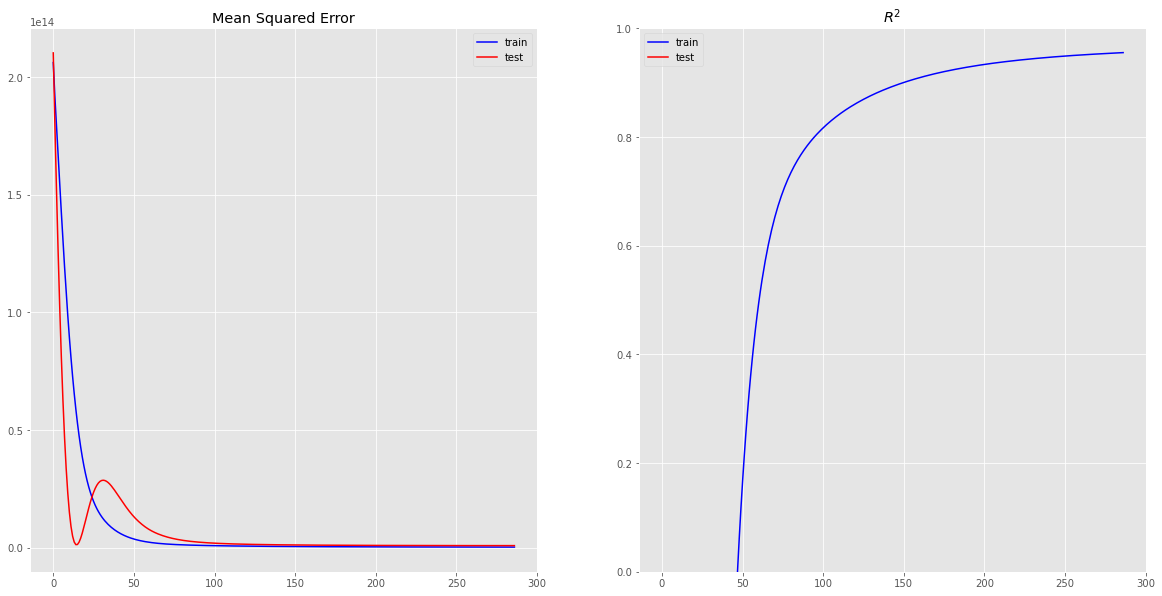

In [214]:
%%time
hidden_units = 512

input_dim = (t_ventana, n_components)

red = MLP(input_dim, hidden_units)
red.to(dev)

loss_function = nn.MSELoss()
optimizer = optim.Adagrad(red.parameters())

epochs = 287
mse_train = []
mse_test = []

r2_train = []
r2_test = []

print("Inicia")
for epoch in range(epochs):
    
    red.zero_grad()
    y_pred = red(X_train_t).to(dev)
    
    loss = loss_function(y_pred, y_train_t)
    mse_train.append(loss)
    r2_train.append( calcular_r2(y_pred, y_train_t ) )
    loss.backward()
    optimizer.step()
    
    # Validate
    y_pred = red(X_test_t).to(dev)
    loss = loss_function(y_pred, y_test_t)
    mse_test.append(loss)
    r2_test.append( calcular_r2(y_pred, y_test_t ) )

print("Termina el entrenamiento")

fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].plot(mse_train, label="train", color="blue")
ax[0].plot(mse_test, label="test", color="red")
ax[0].set_title("Mean Squared Error")
ax[0].legend()


ax[1].plot(r2_train, label="train", color="blue")
ax[1].plot(r2_test, label="test", color="red")
ax[1].set_title("$R^2$")
ax[1].set_ylim(0,1)
ax[1].legend()

In [215]:
torch.Tensor(mse_test).mean().sqrt()

tensor(2754150.7500)

In [216]:
torch.Tensor(mse_test).argmin()

tensor(286)